In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 52kB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None  # default='warn'
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

## Подготовка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/ml-1-Churn.csv')

In [ ]:
df.head()

RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df = df.drop('RowNumber', axis = 1)

In [ ]:
df = df.drop('Surname', axis = 1)

Удаляю столбец с именем, так как айди эквивалентен. Удаляю номер строки, так как индексов достаточно.

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.columns = df.columns.str.lower()

Проверяю на дубликаты. Устанавливаю названия столбцов в нижний регистр для удобства работы.

In [ ]:
df.head()

customerid  creditscore geography  ... isactivemember  estimatedsalary  exited
0    15634602          619    France  ...              1        101348.88       1
1    15647311          608     Spain  ...              1        112542.58       0
2    15619304          502    France  ...              0        113931.57       1
3    15701354          699    France  ...              0         93826.63       0
4    15737888          850     Spain  ...              1         79084.10       0

[5 rows x 12 columns]

In [ ]:
df = pd.get_dummies(df, drop_first = True)

In [ ]:
df.head()

customerid  creditscore  ...  geography_Spain  gender_Male
0    15634602          619  ...                0            0
1    15647311          608  ...                1            0
2    15619304          502  ...                0            0
3    15701354          699  ...                0            0
4    15737888          850  ...                1            0

[5 rows x 13 columns]

Заменяю пол на код: 1 - мужчина, 0 - женщина.
Заменяю страну на код: 1, 0 - Германия, 0, 1 - Испания, 0, 0 - Франция

In [ ]:
df.columns

Index(['customerid', 'creditscore', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited', 'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [ ]:
df.columns = ['customerid', 'creditscore', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited', 'germany', 'spain', 'ismale']

In [ ]:
df.head()

customerid  creditscore  age  tenure  ...  exited  germany  spain  ismale
0    15634602          619   42     2.0  ...       1        0      0       0
1    15647311          608   41     1.0  ...       0        0      1       0
2    15619304          502   42     8.0  ...       1        0      0       0
3    15701354          699   39     1.0  ...       0        0      0       0
4    15737888          850   43     2.0  ...       0        0      1       0

[5 rows x 13 columns]

Переименовываю столбцы для удобства дальнейшей работы.

In [ ]:
df.max()

customerid         15815690.00
creditscore             850.00
age                      92.00
tenure                   10.00
balance              250898.09
numofproducts             4.00
hascrcard                 1.00
isactivemember            1.00
estimatedsalary      199992.48
exited                    1.00
germany                   1.00
spain                     1.00
ismale                    1.00
dtype: float64

In [ ]:
df.min()

customerid         15565701.00
creditscore             350.00
age                      18.00
tenure                    0.00
balance                   0.00
numofproducts             1.00
hascrcard                 0.00
isactivemember            0.00
estimatedsalary          11.58
exited                    0.00
germany                   0.00
spain                     0.00
ismale                    0.00
dtype: float64

Проверяю на наличие аномальных значений.

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       9091 non-null   int64  
 1   creditscore      9091 non-null   int64  
 2   age              9091 non-null   int64  
 3   tenure           9091 non-null   float64
 4   balance          9091 non-null   float64
 5   numofproducts    9091 non-null   int64  
 6   hascrcard        9091 non-null   int64  
 7   isactivemember   9091 non-null   int64  
 8   estimatedsalary  9091 non-null   float64
 9   exited           9091 non-null   int64  
 10  germany          9091 non-null   uint8  
 11  spain            9091 non-null   uint8  
 12  ismale           9091 non-null   uint8  
dtypes: float64(3), int64(7), uint8(3)
memory usage: 807.9 KB


Дропаю пустые строки, так как их не очень много.

## Исследование задачи

In [ ]:
df['exited'].mean()

0.2039379606203938

Только 20% выборки имеет положительный класс.

In [ ]:
df = df.drop(['customerid'], axis = 1)

Дропаю айди, так как при обучении он только помешает.

In [ ]:
df.head()

creditscore  age  tenure    balance  ...  exited  germany  spain  ismale
0          619   42     2.0       0.00  ...       1        0      0       0
1          608   41     1.0   83807.86  ...       0        0      1       0
2          502   42     8.0  159660.80  ...       1        0      0       0
3          699   39     1.0       0.00  ...       0        0      0       0
4          850   43     2.0  125510.82  ...       0        0      1       0

[5 rows x 12 columns]

In [ ]:
target = df['exited']

In [ ]:
features = df.drop(['exited'], axis = 1)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size = 0.5, random_state = 4, stratify = target)

In [ ]:
features_test, features_valid, target_test, target_valid = train_test_split(
features_valid, target_valid, test_size = 0.5, random_state = 4, stratify = target_valid)

In [ ]:
target_train.mean()

0.20396039603960395

In [ ]:
target_test.mean()

0.20413550373955125

In [ ]:
target_valid.mean()

0.20369555653321603

Разбиваю на обучающую, тестовую и валидационную выборку с соотношением: 0.5, 0.25, 0.25. При этом рабиваю равномерно по целевому признаку.

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric = ['creditscore', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'germany', 'spain', 'ismale']

In [ ]:
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
criterion = ['entropy', 'gini']
best_f1 = 0
for est in tqdm(range(5,101,2), desc='Кол-во деревьев:'):
    for depth in tqdm(range(5,21,2), desc='Глубина:', leave=False):
        for crit in criterion:
            model = RandomForestClassifier(max_depth = depth, n_estimators = est, random_state = 4,
                                           criterion = crit)
            model.fit(features_train, target_train)
            proba = model.predict_proba(features_valid)
            for threshold in tqdm(np.arange(0, 0.5, 0.01), desc='Порог:', leave=False):
                predictions = proba[:,1] > threshold
                f = f1_score(target_valid, predictions)
                roc_auc = roc_auc_score(target_valid, predictions) 
                if f>best_f1:
                    best_f1 = f
                    best_depth = depth
                    best_est = est
                    best_roc = roc_auc
                    best_threshold = threshold
                    best_criterion = crit
print(best_depth, best_est, best_f1, best_roc, best_threshold, best_criterion)


9 99 0.6599777034559644 0.7815328806844624 0.33 entropy


Перебираю гиперпараметры для случайного леса.

In [ ]:
model = RandomForestClassifier(max_depth = 9, n_estimators = 99, random_state = 4, criterion = 'entropy')
model.fit(features_train, target_train)
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.33
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

(0.6599777034559644, 0.7815328806844624)

После перебора гиперпараметров на валидационной выборке для случайного леса получаю f1 - 0.66, roc_auc - 0.78, при depth = 9, n_estimators = 99 и порогом = 0.33.

In [ ]:
fpr1, tpr1, thresholds = roc_curve(target_valid, proba[:,1])

Text(0, 0.5, 'TPR')

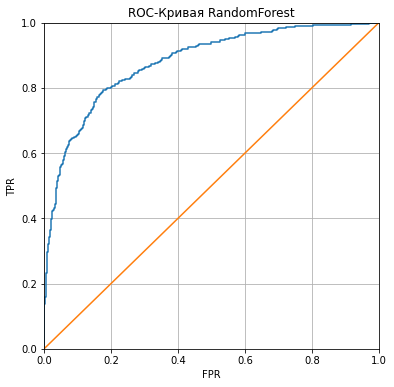

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(fpr1,tpr1)
plt.grid()
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC-Кривая RandomForest')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
best_f1 = 0
model = LogisticRegression(random_state = 4)
model.fit(features_train, target_train)
proba = model.predict_proba(features_valid)
for threshold in np.arange(0, 0.5, 0.01):
        predictions = proba[:,1] > threshold
        f = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, predictions) 
        if f>best_f1:
            best_f1 = f
            best_roc = roc_auc
            best_threshold = threshold
print(best_threshold, best_f1, best_roc)

0.26 0.5057880676758681 0.7028280610479339


Логистическая регрессия показывает результат еще хуже.

In [ ]:
best_f1 = 0
for lr in tqdm(np.arange(0.001, 0.1, 0.001)):
    model = CatBoostClassifier(random_state = 4, eval_metric = 'F1', learning_rate = lr, verbose = False)
    model.fit(features_train, target_train, eval_set=(features_valid, target_valid))
    proba = model.predict_proba(features_valid)
    for threshold in np.arange(0, 0.5, 0.01):
        predictions = proba[:,1] > threshold
        f = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, predictions) 
        if f>best_f1:
            best_f1 = f
            best_roc = roc_auc
            best_threshold = threshold
            best_lr = lr
print(best_threshold, best_f1, best_roc, best_lr)


0.27 0.6693147964250248 0.8067485650871687 0.006


In [ ]:
model = CatBoostClassifier(random_state = 4, eval_metric = 'F1', learning_rate = 0.006, verbose = 100)
model.fit(features_train, target_train, eval_set=(features_valid, target_valid))
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.27
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

0:	learn: 0.4639543	test: 0.4556962	best: 0.4556962 (0)	total: 3.7ms	remaining: 3.69s
100:	learn: 0.4984848	test: 0.5198238	best: 0.5454545 (8)	total: 348ms	remaining: 3.1s
200:	learn: 0.5223881	test: 0.5391304	best: 0.5454545 (8)	total: 710ms	remaining: 2.82s
300:	learn: 0.5433186	test: 0.5514286	best: 0.5514286 (296)	total: 1.07s	remaining: 2.48s
400:	learn: 0.5532223	test: 0.5576102	best: 0.5596591 (379)	total: 1.42s	remaining: 2.12s
500:	learn: 0.5753034	test: 0.5782123	best: 0.5782123 (498)	total: 1.77s	remaining: 1.77s
600:	learn: 0.6015352	test: 0.5906593	best: 0.5906593 (600)	total: 2.12s	remaining: 1.41s
700:	learn: 0.6092991	test: 0.5909713	best: 0.5909713 (661)	total: 2.47s	remaining: 1.05s
800:	learn: 0.6217331	test: 0.5964912	best: 0.5964912 (772)	total: 2.83s	remaining: 704ms
900:	learn: 0.6352459	test: 0.5967742	best: 0.5983827 (870)	total: 3.18s	remaining: 349ms
999:	learn: 0.6430518	test: 0.6050870	best: 0.6050870 (994)	total: 3.54s	remaining: 0us

bestTest = 0.6050870

(0.6693147964250248, 0.8067485650871687)

После перебора гиперпараметров на валидационной выборке для кэтбуста получаю f1 - 0.60, roc_auc - 0.80, при learning_rate = 0.006 и порогом = 0.27.

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, proba[:,1])

Text(0, 0.5, 'TPR')

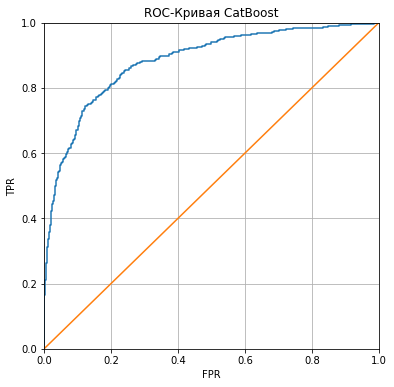

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr)
plt.grid()
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC-Кривая CatBoost')
plt.xlabel('FPR')
plt.ylabel('TPR')

Text(0, 0.5, 'TPR')

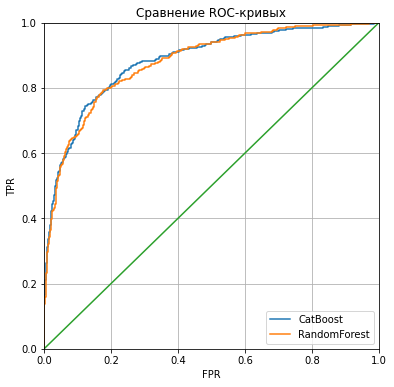

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr)
plt.plot(fpr1,tpr1)
plt.legend(['CatBoost', 'RandomForest'])
plt.grid()
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Сравнение ROC-кривых')
plt.xlabel('FPR')
plt.ylabel('TPR')

## Борьба с дисбалансом

In [ ]:
features_zeros = features_train[target_train == 0]

In [ ]:
features_ones = features_train[target_train == 1]

In [ ]:
target_zeros = target_train[target_train == 0]

In [ ]:
target_ones = target_train[target_train == 1]

In [ ]:
features_train_d = pd.concat([features_zeros.sample(frac = 0.20, random_state = 4)]+[features_ones])

In [ ]:
target_train_d = pd.concat([target_zeros.sample(frac = 0.20, random_state = 4)]+[target_ones])

In [ ]:
features_train_d, target_train_d = shuffle(features_train_d, target_train_d, random_state = 4)

In [ ]:
target_train_d.mean()

0.5614778921865536

In [ ]:
features_train_d.shape

(1651, 11)

In [ ]:
target_train_d.shape

(1651,)

In [ ]:
model = RandomForestClassifier(max_depth = 9, n_estimators = 99, random_state = 4, criterion = 'entropy')
model.fit(features_train_d, target_train_d)
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.33
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

(0.46080508474576276, 0.6962817560230541)

In [ ]:
model = CatBoostClassifier(random_state = 4, eval_metric = 'F1', learning_rate = 0.006, verbose = 100)
model.fit(features_train_d, target_train_d, eval_set=(features_valid, target_valid))
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.27
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

0:	learn: 0.7431884	test: 0.5809129	best: 0.5809129 (0)	total: 2.89ms	remaining: 2.88s
100:	learn: 0.8092176	test: 0.5871560	best: 0.5903151 (88)	total: 239ms	remaining: 2.13s
200:	learn: 0.8200431	test: 0.5932865	best: 0.5942142 (190)	total: 477ms	remaining: 1.9s
300:	learn: 0.8250540	test: 0.5942591	best: 0.5962441 (246)	total: 735ms	remaining: 1.71s
400:	learn: 0.8334238	test: 0.5928793	best: 0.5962441 (246)	total: 992ms	remaining: 1.48s
500:	learn: 0.8436482	test: 0.5961089	best: 0.5965732 (498)	total: 1.23s	remaining: 1.22s
600:	learn: 0.8495671	test: 0.5939205	best: 0.5979703 (503)	total: 1.46s	remaining: 968ms
700:	learn: 0.8557484	test: 0.6028257	best: 0.6028257 (699)	total: 1.7s	remaining: 724ms
800:	learn: 0.8631922	test: 0.6026542	best: 0.6045419 (755)	total: 1.95s	remaining: 484ms
900:	learn: 0.8670646	test: 0.5973417	best: 0.6045419 (755)	total: 2.19s	remaining: 241ms
999:	learn: 0.8715447	test: 0.5964091	best: 0.6045419 (755)	total: 2.42s	remaining: 0us

bestTest = 0.6045

(0.4499746063991874, 0.684755319021992)

Даунсэмплинг только уменьшил значение f1 для обоих моделей

In [ ]:
features_train_up = pd.concat([features_zeros]+[features_ones] * 5)

In [ ]:
target_train_up = pd.concat([target_zeros]+[target_ones] * 5)

In [ ]:
features_train_up, target_train_up = shuffle(features_train_up, target_train_up, random_state = 4)

In [ ]:
target_train_up.mean()

0.5616139585605234

In [ ]:
model = RandomForestClassifier(max_depth = 9, n_estimators = 99, random_state = 4, criterion = 'entropy')
model.fit(features_train_up, target_train_up)
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.33
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

(0.5187461585740626, 0.7507511664260229)

In [ ]:
model = CatBoostClassifier(random_state = 4, eval_metric = 'F1', learning_rate = 0.006, verbose = 100)
model.fit(features_train_up, target_train_up, eval_set=(features_valid, target_valid))
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.27
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

0:	learn: 0.7937310	test: 0.5263861	best: 0.5263861 (0)	total: 8.03ms	remaining: 8.02s
100:	learn: 0.8129212	test: 0.5933897	best: 0.5946360 (98)	total: 530ms	remaining: 4.71s
200:	learn: 0.8162609	test: 0.6007722	best: 0.6017015 (193)	total: 1.05s	remaining: 4.18s
300:	learn: 0.8253730	test: 0.6091052	best: 0.6095837 (285)	total: 1.6s	remaining: 3.72s
400:	learn: 0.8274079	test: 0.6128266	best: 0.6139241 (388)	total: 2.15s	remaining: 3.21s
500:	learn: 0.8315381	test: 0.6125696	best: 0.6141607 (472)	total: 2.71s	remaining: 2.7s
600:	learn: 0.8369284	test: 0.6157556	best: 0.6168675 (597)	total: 3.25s	remaining: 2.15s
700:	learn: 0.8446309	test: 0.6176233	best: 0.6181230 (672)	total: 3.8s	remaining: 1.62s
800:	learn: 0.8502852	test: 0.6211382	best: 0.6221498 (783)	total: 4.35s	remaining: 1.08s
900:	learn: 0.8551146	test: 0.6219313	best: 0.6229508 (885)	total: 4.89s	remaining: 537ms
999:	learn: 0.8594757	test: 0.6189300	best: 0.6229508 (885)	total: 5.44s	remaining: 0us

bestTest = 0.62295

(0.4879416713404374, 0.7252872808849324)

Апсэмплинг так же только уменьшил значение f1.

In [ ]:
model = RandomForestClassifier(max_depth = 9, n_estimators = 99, random_state = 4, criterion = 'entropy',
                               class_weight = {0:1, 1:5})
model.fit(features_train, target_train)
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.33
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

(0.5452091767881241, 0.7663955944297937)

In [ ]:
model = CatBoostClassifier(random_state = 4, eval_metric = 'F1', learning_rate = 0.006,
                           verbose = 100, class_weights = [1, 5])
model.fit(features_train, target_train, eval_set=(features_valid, target_valid))
proba = model.predict_proba(features_valid)
predictions = proba[:,1] > 0.37
f = f1_score(target_valid, predictions)
roc_auc = roc_auc_score(target_valid, predictions) 

f, roc_auc

0:	learn: 0.7715298	test: 0.7875055	best: 0.7875055 (0)	total: 4.12ms	remaining: 4.12s
100:	learn: 0.8100320	test: 0.8197069	best: 0.8209588 (98)	total: 395ms	remaining: 3.52s
200:	learn: 0.8128605	test: 0.8161091	best: 0.8209588 (98)	total: 776ms	remaining: 3.08s
300:	learn: 0.8207759	test: 0.8197774	best: 0.8209588 (98)	total: 1.15s	remaining: 2.68s
400:	learn: 0.8268264	test: 0.8253154	best: 0.8253154 (400)	total: 1.51s	remaining: 2.26s
500:	learn: 0.8272610	test: 0.8233276	best: 0.8253154 (400)	total: 1.91s	remaining: 1.9s
600:	learn: 0.8314559	test: 0.8263576	best: 0.8263576 (592)	total: 2.29s	remaining: 1.52s
700:	learn: 0.8353017	test: 0.8277790	best: 0.8292159 (672)	total: 2.68s	remaining: 1.14s
800:	learn: 0.8401288	test: 0.8244969	best: 0.8292159 (672)	total: 3.05s	remaining: 757ms
900:	learn: 0.8444968	test: 0.8253899	best: 0.8292159 (672)	total: 3.42s	remaining: 376ms
999:	learn: 0.8495613	test: 0.8257477	best: 0.8292159 (672)	total: 3.81s	remaining: 0us

bestTest = 0.82921

(0.5390524967989757, 0.7673508108301612)

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px">Изменение параметров веса классов так же только ухудшило метрики.</div>

## Тестирование модели

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px">Для тестирования выбран CatBoost, так как он показал наибольшее значение метрики f1 по сравнении с остальными моделями.</div>

In [ ]:
features_train = pd.concat([features_train] + [features_valid])

In [ ]:
target_train = pd.concat([target_train] + [target_valid])

In [ ]:
features_train, target_train = shuffle(features_train, target_train, random_state = 4)

In [ ]:
model = CatBoostClassifier(random_state = 4,learning_rate = 0.006, verbose = 100)
model.fit(features_train, target_train)
proba = model.predict_proba(features_test)
predictions = proba[:,1] > 0.27
f = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, predictions) 

f, roc_auc

0:	learn: 0.6884307	total: 5.06ms	remaining: 5.05s
100:	learn: 0.4324882	total: 446ms	remaining: 3.97s
200:	learn: 0.3678207	total: 912ms	remaining: 3.62s
300:	learn: 0.3426882	total: 1.38s	remaining: 3.2s
400:	learn: 0.3298476	total: 1.81s	remaining: 2.71s
500:	learn: 0.3219656	total: 2.26s	remaining: 2.25s
600:	learn: 0.3160563	total: 2.71s	remaining: 1.8s
700:	learn: 0.3112671	total: 3.17s	remaining: 1.35s
800:	learn: 0.3071765	total: 3.62s	remaining: 900ms
900:	learn: 0.3034081	total: 4.08s	remaining: 448ms
999:	learn: 0.3001729	total: 4.51s	remaining: 0us


(0.6054490413723511, 0.7605340157450297)

## Вывод

В процессе исследования были выполнены следующие работы.

Предобработка данных:
- удалены ненужные столбцы: RowNumber, CustomerId, Surname;
- удалены строки с пустыми значениями;
- проверены данные на наличие аномальных значений;
- изменены названия строк для удобства дальнейшей работы;
- применен инструмент OHE для обработки признаков (Пол, Страна);
- применен инструмент StandardScaler для масштабирования всех признаков.

Исследование задачи:
- определен баланс классов: 20% положительный, 80% отрицательный;
- данные разбиты на три выборки: 75% тренировочная, 25% валидационная, 25% тестовая;
- применено три модели, получившие следующие показатели метрик:
    - Случайный лес: f1_score 0.66, roc_auc_score 0.78;
    - Логистическая регрессия: f1_score 0.50, roc_auc_score 0.70;
    - Кэтбуст: f1_score 0.66, roc_auc_score 0.80;
- для дальнейшей работы с дисбалансом выбраны Случайный лес и Кэтбуст.   

Работа с дисбалансом

Применены техники ампсэмплинга и даунсэмплинга. Для обоих моделей применение данных техник только ухудшило показатели f1-score.

Тестирование модели

Для тестирования выбрана модель Кэтбуст с параметром learning_rate 0.006 и порогом положительного класса 0.27. На тестировочной выборке Кэтбуст показал значение f1-меры 0.62. Задача выполнена.